In [1]:
import os
import numpy as np
import keras
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Reshape
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
!pip install -q keras

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
Train Set Size = 50000 images
Test Set Size = 10000 images


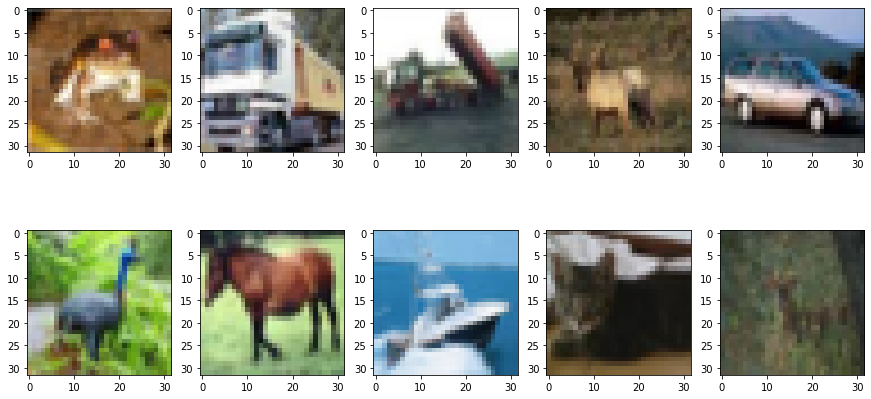

Labels : [[6]
 [9]
 [9]
 [4]
 [1]]
Labels : [[2]
 [7]
 [8]
 [3]
 [4]]


In [4]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [0]:
y_train_onehot = to_categorical(y_train, num_classes=None, dtype='float32')

In [0]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def vgg16():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=((32, 32, 3)), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = vgg16()

In [0]:
nb_epoch = 50
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train, y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [8]:
%%time
predictions, history = run_vgg16()
print(model.summary())

Train on 37500 samples, validate on 12500 samples
Epoch 1/50
37500/37500 [==============================] - 20s 542us/step - loss: 0.3016 - accuracy: 0.8998 - val_loss: 0.2706 - val_accuracy: 0.9019
Epoch 2/50
37500/37500 [==============================] - 13s 334us/step - loss: 0.2578 - accuracy: 0.9048 - val_loss: 0.2349 - val_accuracy: 0.9130
Epoch 3/50
37500/37500 [==============================] - 12s 333us/step - loss: 0.2269 - accuracy: 0.9148 - val_loss: 0.2076 - val_accuracy: 0.9213
Epoch 4/50
37500/37500 [==============================] - 13s 333us/step - loss: 0.2013 - accuracy: 0.9243 - val_loss: 0.1769 - val_accuracy: 0.9316
Epoch 5/50
37500/37500 [==============================] - 13s 334us/step - loss: 0.1782 - accuracy: 0.9330 - val_loss: 0.1810 - val_accuracy: 0.9320
Epoch 6/50
37500/37500 [==============================] - 13s 334us/step - loss: 0.1573 - accuracy: 0.9406 - val_loss: 0.1697 - val_accuracy: 0.9359
Epoch 7/50
37500/37500 [==============================] 

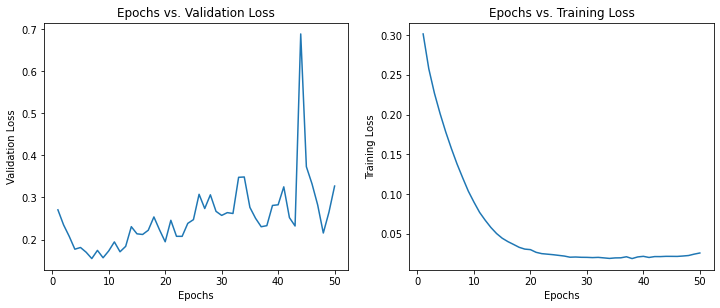

In [9]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,nb_epoch+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

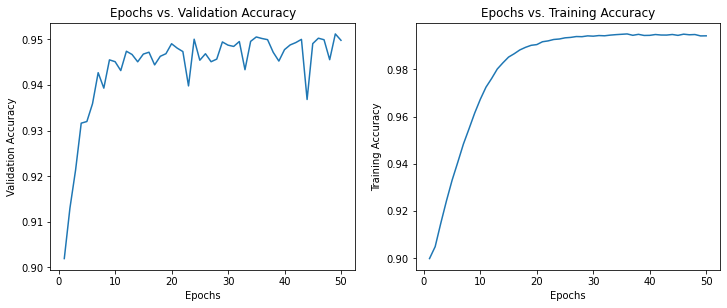

In [10]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_acc)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,nb_epoch+1), history.acc)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [11]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 73.71 %


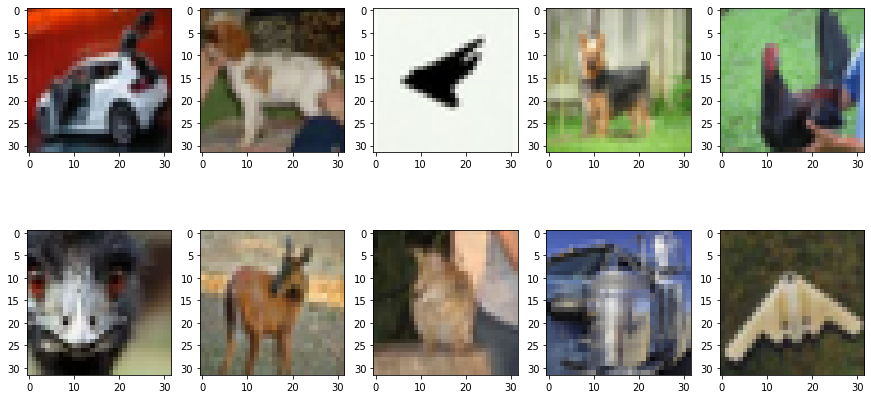

True:          [[1]
 [5]
 [0]
 [5]
 [2]]
classified as: [9 3 2 4 5]
True:          [[2]
 [4]
 [3]
 [9]
 [0]]
classified as: [8 7 5 7 6]


In [12]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))